**Gabriela Tanumihardja**</br>
**Capstone Project - Part VIIA** </br>
**Data prep for BERT Multiclass**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
import datetime
from sklearn.feature_extraction.text import CountVectorizer
%config InlineBackend.figure_format='retina'
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
from nltk.corpus import stopwords
import string
from operator import itemgetter
from wordcloud import WordCloud

%matplotlib inline

***

Previously, I was successful in training a model to perform a binary classification (satire/legitimate). Now I would like to modify the model to predict the news source for each headline. For this task I would need to make sure my target variable categories are balanced. I will now begin with reading in the data.

In [9]:
# read in data

df = pd.read_csv('data/year_sampled.csv', index_col = 0)

In [10]:
# check

df.head()

,index,title,topic,date_published,source,satire,year
0,10523,Divorced Mom At Point In Life Where She Figure...,local,2020-03-16 15:39:00+00:00,the onion,1,2020
1,10440,Unclear Why Only One Half Of Couple Wearing Mask,local,2020-05-20 18:42:00+00:00,the onion,1,2020
2,3675,"Jessie Fleming turns pro, signs deal with Che...",sports,2020-07-22 14:25:21.526000+00:00,the globe and mail,0,2020
3,5440,Full Stream Ahead: Your best action movie bet...,arts,2020-04-30 21:50:59.493000+00:00,the globe and mail,0,2020
4,533,COVID-19 in Quebec: Province reports 133 new ...,canada,2020-08-06 16:04:46.296000+00:00,the globe and mail,0,2020


In [11]:
# Check!

df['source'].unique()

array(['the onion', 'the globe and mail', 'beaverton', 'nyt'],
      dtype=object)

Now, I would code the sources into codes. I will add a new column for this.

In [12]:
# Add a new column for source_code

df.loc[df['source'] == 'beaverton', 'source_code'] = 0
df.loc[df['source'] == 'the globe and mail', 'source_code'] = 1
df.loc[df['source'] == 'the onion', 'source_code'] = 2
df.loc[df['source'] == 'nyt', 'source_code'] = 3

In [13]:
# Check

df.head()

,index,title,topic,date_published,source,satire,year,source_code
0,10523,Divorced Mom At Point In Life Where She Figure...,local,2020-03-16 15:39:00+00:00,the onion,1,2020,2.0
1,10440,Unclear Why Only One Half Of Couple Wearing Mask,local,2020-05-20 18:42:00+00:00,the onion,1,2020,2.0
2,3675,"Jessie Fleming turns pro, signs deal with Che...",sports,2020-07-22 14:25:21.526000+00:00,the globe and mail,0,2020,1.0
3,5440,Full Stream Ahead: Your best action movie bet...,arts,2020-04-30 21:50:59.493000+00:00,the globe and mail,0,2020,1.0
4,533,COVID-19 in Quebec: Province reports 133 new ...,canada,2020-08-06 16:04:46.296000+00:00,the globe and mail,0,2020,1.0


In [23]:
# Check!

df['source_code'].unique()

array([2., 1., 0., 3.])

As it stands currently, the source code is stored as a float and not a string. To make things neat, I will transform this to integer type. 

In [14]:
# transform column to integer

import numpy as np
df['source_code'] = df['source_code'].apply(np.int64)

In [16]:
# Check!

df.head()

,index,title,topic,date_published,source,satire,year,source_code
0,10523,Divorced Mom At Point In Life Where She Figure...,local,2020-03-16 15:39:00+00:00,the onion,1,2020,2
1,10440,Unclear Why Only One Half Of Couple Wearing Mask,local,2020-05-20 18:42:00+00:00,the onion,1,2020,2
2,3675,"Jessie Fleming turns pro, signs deal with Che...",sports,2020-07-22 14:25:21.526000+00:00,the globe and mail,0,2020,1
3,5440,Full Stream Ahead: Your best action movie bet...,arts,2020-04-30 21:50:59.493000+00:00,the globe and mail,0,2020,1
4,533,COVID-19 in Quebec: Province reports 133 new ...,canada,2020-08-06 16:04:46.296000+00:00,the globe and mail,0,2020,1


I think it's now is the time to see the distribution of article sources.

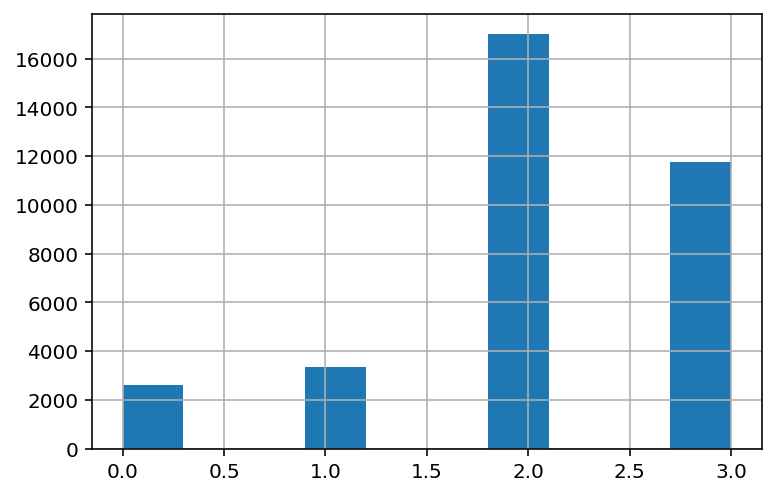

In [18]:
# check out the article source distribution

df['source_code'].hist();

Whewww there are definitely more articles coming from the onion and the nyt than ones coming from the globe and mail. I will now resample the articles from nyt and the onions to be 3000 each. I think that would be a fair amount to make things more balanced. As previously done, I will sample without replacement.

In [19]:
# separate data by sources

df_0 =  df[df.source_code == 0]
df_1 =  df[df.source_code == 1]
df_2 =  df[df.source_code == 2]
df_3 =  df[df.source_code == 3]

In [20]:
from sklearn.utils import resample

# downsample the onion and the nyt
df_2_downsampled = resample(df_2, 
                            replace=False,
                            n_samples=3000,
                            random_state=99)
df_3_downsampled = resample(df_3, 
                            replace=False,
                            n_samples=3000,
                            random_state=99)

# combine all the data
df_downsampled = pd.concat([df_0, df_1, df_2_downsampled, df_3_downsampled])
 

In [39]:
# check

df_downsampled.shape

(11960, 7)

Our final df still have almost 12,000 data points, which should be enough to train a model.  I will now check for the distribution once more.

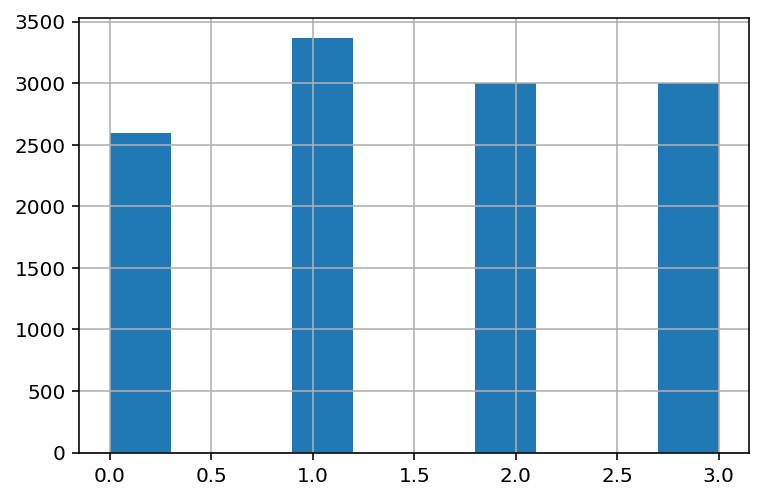

In [21]:
# check distribution

df_downsampled['source_code'].hist();

The data is more or less balance now. I will perform a train test split with this data. I will only need a train and test set for this data as I will use the BERT model for this data and TF does cross validation automatically.

In [24]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_downsampled, test_size = 0.2, random_state = 99, stratify = df_downsampled['source_code'])

In [25]:
# Check

train.shape

(9568, 8)

In [26]:
# Check

test.shape

(2392, 8)

I will save the train and test data to csv for convenience now.

In [46]:
train.to_csv('data/BERT_data/train_multi.csv')

In [47]:
test.to_csv('data/BERT_data/test_multi.csv')

I will now fit this data into a 4 classes classification BERT model.